In [1]:
# Freeing CUDA memory: https://stackoverflow.com/questions/55322434/how-to-clear-cuda-memory-in-pytorch 
import torch 
from SPN import SPN 
from matplotlib import pyplot as plt 
from utils import * 
import os 
import matplotlib.pyplot as plt 
from torchinfo import summary 
import numpy as np 
from inference import inference 
from pathlib import Path 
import time
from tqdm import tqdm

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

print("Running on: " , device) 

num_facilities = np.linspace(20,200,10) # number of facilities 

city_dim = 2
Data_1 = []
Data_2 = []
Data_3 = []
Data_4 = []
for i in num_facilities:
    i = int(i)
    # data = torch.tile(torch.rand(i, city_dim), (1, 1, 1)).to(device) # 1 drone
    data = torch.rand(1,i,city_dim).to(device) # 1 drone
    Data_1.append(data)
    # data = torch.tile(torch.rand(i, city_dim), (50, 1, 1)).to(device) # 50 drones
    data = torch.rand(50,i,city_dim).to(device) # 50 drones
    Data_2.append(data)
    # data = torch.tile(torch.rand(i, city_dim), (100, 1, 1)).to(device) # 100 drones
    data = torch.rand(100,i,city_dim).to(device) # 100 drones
    Data_3.append(data)
    # data = torch.tile(torch.rand(i, city_dim), (200, 1, 1)).to(device) # 100 drones
    data = torch.rand(200,i,city_dim).to(device) # 200 drones
    Data_4.append(data)

Running on:  cuda


In [9]:
num_facilities

array([ 20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.])

In [4]:
torch.cuda.empty_cache()
model_classes = {"SPN": SPN}
weights_address = (
    Path("Saved_models") /
    "FT100_FastAnneal_2025_07_19_01_50_51.pth"
)
spn = load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in spn.parameters():
    param.requires_grad = False
spn.eval()
print('SPN loaded.')
print(summary(spn))


Model created.
SPN loaded.
Layer (type:depth-idx)                                       Param #
SPN                                                          --
├─LinearAttnEncoder: 1-1                                     2,048
│    └─ModuleList: 2-1                                       --
│    │    └─MultiheadAttention: 3-1                          (66,048)
│    │    └─MultiheadAttention: 3-2                          (66,048)
│    │    └─MultiheadAttention: 3-3                          (66,048)
│    │    └─MultiheadAttention: 3-4                          (66,048)
│    │    └─MultiheadAttention: 3-5                          (66,048)
│    │    └─MultiheadAttention: 3-6                          (66,048)
│    └─ModuleList: 2-2                                       --
│    │    └─MultiheadAttention: 3-7                          (66,048)
│    │    └─MultiheadAttention: 3-8                          (66,048)
│    │    └─MultiheadAttention: 3-9                          (66,048)
│    │    └─Mul

# Test probability generation for UAV_FLPO

In [5]:
data = Data_1[0]
labels0, actions0 = generate_true_labels(data, beta=1e8)
labels1, actions1 = generate_true_labels1(data, beta=1e8)

# Calculating time for SNN

In [10]:

times_1_L=[]
times_2_L=[]
times_3_L=[]
times_4_L=[]
torch.cuda.empty_cache()
for data in tqdm(Data_1):
    s = time.time()
    with torch.no_grad():
        inference(data,spn,'Greedy')
    times_1_L.append(time.time()-s)
    torch.cuda.empty_cache()
for data in tqdm(Data_2):
    s = time.time()
    with torch.no_grad():
        inference(data,spn,'Greedy')
    times_2_L.append(time.time()-s)
    torch.cuda.empty_cache()
for data in tqdm(Data_3):
    s = time.time()
    with torch.no_grad():
        inference(data,spn,'Greedy')
    times_3_L.append(time.time()-s)
    torch.cuda.empty_cache()
for data in tqdm(Data_4):
    s = time.time()
    with torch.no_grad():
        inference(data,spn,'Greedy')
    times_4_L.append(time.time()-s)
    torch.cuda.empty_cache()

100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


# Calculating time for Original Gibb's Distribution

In [12]:
times_1_G=[]
times_2_G=[]
times_3_G=[]
times_4_G=[]
torch.cuda.empty_cache()
for data in tqdm(Data_1):
    s = time.time()
    with torch.no_grad():
        generate_true_labels1(data,10)
    times_1_G.append(time.time()-s)
    torch.cuda.empty_cache()
for data in tqdm(Data_2):
    s = time.time()
    with torch.no_grad():
        generate_true_labels1(data,10)
    times_2_G.append(time.time()-s)
    torch.cuda.empty_cache()
for data in tqdm(Data_3):
    s = time.time()
    with torch.no_grad():
        generate_true_labels1(data,10)
    times_3_G.append(time.time()-s)
    torch.cuda.empty_cache()
for data in tqdm(Data_4):
    s = time.time()
    with torch.no_grad():
        generate_true_labels1(data,10)
    times_4_G.append(time.time()-s)
    torch.cuda.empty_cache()

100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


# Save the data

In [14]:
import pickle

action_runtime_data = {}

action_runtime_data['times_1_L'] = times_1_L
action_runtime_data['times_2_L'] = times_2_L
action_runtime_data['times_3_L'] = times_3_L
action_runtime_data['times_4_L'] = times_4_L

action_runtime_data['times_1_G'] = times_1_G
action_runtime_data['times_2_G'] = times_2_G
action_runtime_data['times_3_G'] = times_3_G
action_runtime_data['times_4_G'] = times_4_G

filename = 'InferenceSpeedResults.pkl'
with open(filename, 'wb') as file:
    pickle.dump(action_runtime_data, file)


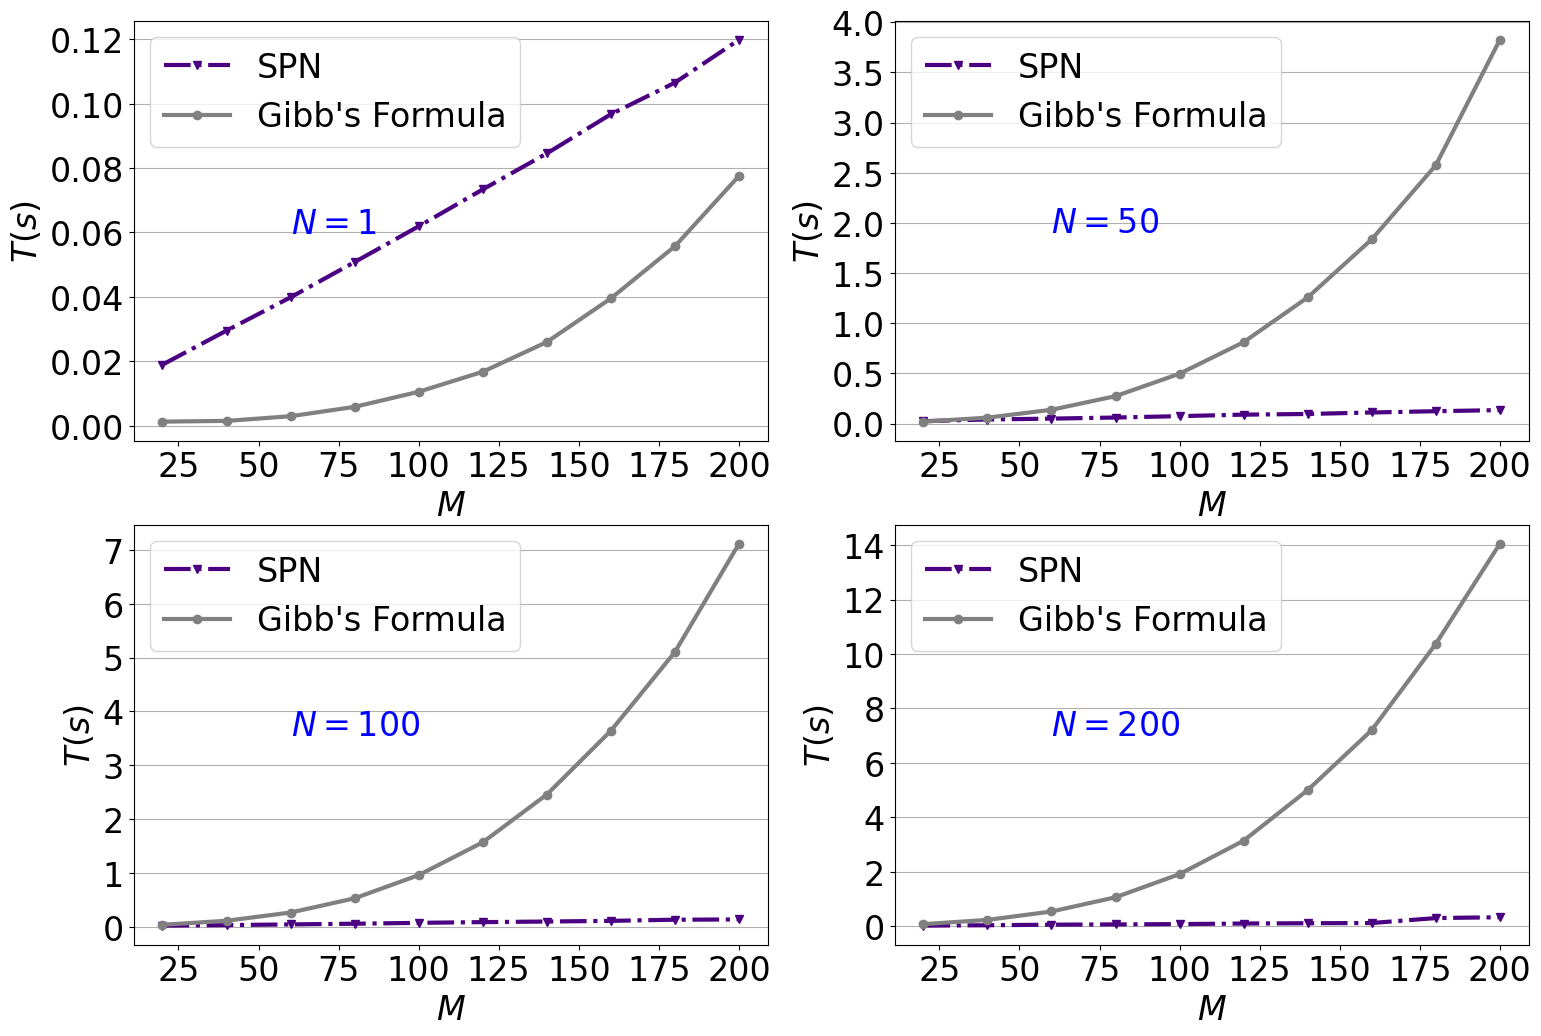

In [18]:
color1 = 'indigo'
color2 = 'gray'
color3 = 'orange'
linestyle1 = '-.'
linestyle2 = '-'
linestyle3 = '--'
Label1 = "SPN"
Label2 = "Gibb's Formula"
fontsize1 = 24
fontsize2 = 24
linewidth1 = 3

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.plot(num_facilities,times_1_L,linestyle1,linewidth=linewidth1,marker='v',color=color1,label=Label1)
plt.plot(num_facilities,times_1_G,linestyle2,linewidth=linewidth1,marker='o',color=color2,label=Label2)
# plt.yscale('log')
plt.text(num_facilities[2],times_1_L[-1]*0.5,"$N=1$",fontsize=fontsize1,color='blue',weight='bold')
plt.xlabel(rf'$M$', fontsize=fontsize1)
plt.ylabel(rf'$T(s)$', fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.grid(axis='y',alpha=1)
plt.legend(fontsize=fontsize1)

plt.subplot(2,2,2)
plt.plot(num_facilities,times_2_L,linestyle1,linewidth=linewidth1,marker='v',color=color1,label=Label1)
plt.plot(num_facilities,times_2_G,linestyle2,linewidth=linewidth1,marker='o',color=color2,label=Label2)
# plt.yscale('log')
plt.text(num_facilities[2],times_2_G[-1]*0.5,"$N=50$",fontsize=fontsize1,color='blue',weight='bold')
plt.xlabel(rf'$M$', fontsize=fontsize1)
plt.ylabel(rf'$T(s)$', fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.grid(axis='y',alpha=1)
plt.legend(fontsize=fontsize1)

plt.subplot(2,2,3)
plt.plot(num_facilities,times_3_L,linestyle1,linewidth=linewidth1, marker='v',color=color1,label=Label1)
plt.plot(num_facilities,times_3_G,linestyle2,linewidth=linewidth1, marker='o',color=color2,label=Label2)
# plt.yscale('log')
plt.text(num_facilities[2],times_3_G[-1]*0.5,"$N=100$",fontsize=fontsize1,color='blue',weight='bold')
plt.xlabel(rf'$M$', fontsize=fontsize1)
plt.ylabel(rf'$T(s)$', fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.grid(axis='y',alpha=1)
plt.legend(fontsize=fontsize1)


plt.subplot(2,2,4)
plt.plot(num_facilities,times_4_L,linestyle1,linewidth=linewidth1,marker='v',color=color1,label=Label1)
plt.plot(num_facilities,times_4_G,linestyle2,linewidth=linewidth1,marker='o',color=color2,label=Label2)
# plt.yscale('log')
plt.xlabel('Num F')
plt.ylabel('T(s)')
plt.text(num_facilities[2],times_4_G[-1]*0.5,"$N=200$",fontsize=fontsize1,color='blue',weight='bold')
plt.xlabel(rf'$M$', fontsize=fontsize1)
plt.ylabel(rf'$T(s)$', fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.grid(axis='y',alpha=1)
plt.legend(fontsize=fontsize1)


# plt.plot(num_facilities,times_1_L,linestyle1,marker='v',color=color1,label='SPN_1')
# plt.plot(num_facilities,times_2_L,linestyle1,marker='o',color=color1,label='SPN_50')
# plt.plot(num_facilities,times_3_L,linestyle1,marker='^',color=color1,label='SPN_100')
# plt.plot(num_facilities,times_4_L,linestyle1,marker='x',color=color1,label='SPN_200')

# plt.plot(num_facilities,times_1_F,linestyle2,marker='v',color=color2,label='FLPO_1')
# plt.plot(num_facilities,times_2_F,linestyle2,marker='o',color=color2,label='FLPO_50')
# plt.plot(num_facilities,times_3_F,linestyle2,marker='^',color=color2,label='FLPO_100')
# plt.plot(num_facilities,times_4_F,linestyle2,marker='x',color=color2,label='FLPO_200')

# plt.plot(num_facilities,times_1_G,linestyle3,marker='v',color=color3,label='FLPO_DP_1')
# plt.plot(num_facilities,times_2_G,linestyle3,marker='o',color=color3,label='FLPO_DP_50')
# plt.plot(num_facilities,times_3_G,linestyle3,marker='^',color=color3,label='FLPO_DP_100')
# plt.plot(num_facilities,times_4_F,linestyle3,marker='x',color=color3,label='FLPO_DP_200')

# plt.legend()
# plt.title('GPU Runtime Comparison (Total Route)')
plt.savefig("SpeedTestResults.svg")

plt.show()
